In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tongue-all/Tongue_Features.xlsx
/kaggle/input/tongue-all/Tongue Palette Yolo Cropped/Tongue Palette Yolo Cropped/1709793682402.jpg
/kaggle/input/tongue-all/Tongue Palette Yolo Cropped/Tongue Palette Yolo Cropped/1709982568772.jpg
/kaggle/input/tongue-all/Tongue Palette Yolo Cropped/Tongue Palette Yolo Cropped/1709708320994.jpg
/kaggle/input/tongue-all/Tongue Palette Yolo Cropped/Tongue Palette Yolo Cropped/1709800877068.jpg
/kaggle/input/tongue-all/Tongue Palette Yolo Cropped/Tongue Palette Yolo Cropped/1709712334590.jpg
/kaggle/input/tongue-all/Tongue Palette Yolo Cropped/Tongue Palette Yolo Cropped/1709971033212.jpg
/kaggle/input/tongue-all/Tongue Palette Yolo Cropped/Tongue Palette Yolo Cropped/1709617694248.jpg
/kaggle/input/tongue-all/Tongue Palette Yolo Cropped/Tongue Palette Yolo Cropped/1709635624336.jpg
/kaggle/input/tongue-all/Tongue Palette Yolo Cropped/Tongue Palette Yolo Cropped/1709701638747.jpg
/kaggle/input/tongue-all/Tongue Palette Yolo Cropped/Tongue Pal

In [2]:
import pandas as pd 
df = pd.read_excel('/kaggle/input/tongue-all/Tongue_Features.xlsx')
df = df[['Image_Name','Hb Value']]
df.head()

,Image_Name,Hb Value
0,1709617694248.jpg,11.5
1,1709617844626.jpg,11.6
2,1709619191362.jpg,11.1
3,1709619874657.jpg,12.1
4,1709620272757.jpg,12.2


In [3]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.15, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.176, random_state=42)

In [4]:
print('train_df shape',train_df.shape)
print('test_df shape',test_df.shape)
print('tval_df shape',val_df.shape)

train_df shape (290, 2)
test_df shape (63, 2)
tval_df shape (63, 2)


In [6]:

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image

def load_image_and_label(image_file, label):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # ResNet50 expects 224x224
    # Scale pixel values [0, 1] or standardize them
    image = image / 255.0
    return image, label

def create_tf_dataset(df, images_folder, batch_size=8, shuffle=True):
    # Construct full paths to images
    image_paths = [os.path.join(images_folder, img) for img in df['Image_Name'].values]
    labels = df['Hb Value'].values.astype(np.float32)

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(load_image_and_label, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Create datasets
train_ds = create_tf_dataset(train_df, "/kaggle/input/tongue-all/Tongue Masked/Tongue Masked", batch_size=16, shuffle=True)
val_ds   = create_tf_dataset(val_df,   "/kaggle/input/tongue-all/Tongue Masked/Tongue Masked", batch_size=16, shuffle=False)
test_ds  = create_tf_dataset(test_df,  "/kaggle/input/tongue-all/Tongue Masked/Tongue Masked", batch_size=16, shuffle=False)


In [7]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

def build_model(input_shape=(224, 224, 3)):
    # Load ResNet50 without the top classification layers
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)


    for layer in base_model.layers:
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # Add your own fully connected layers if desired
    # x = Dense(128, activation='relu')(x)
    # x = Dropout(0.3)(x)

    # Final regression output (1 dimension: predicted Hb)
    predictions = Dense(1, activation='linear')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model


In [8]:
model = build_model(input_shape=(224, 224, 3))
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mean_squared_error',  # or 'mae'
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
epochs = 100
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - loss: 54.4574 - mean_absolute_error: 6.1225 - val_loss: 150.4276 - val_mean_absolute_error: 12.1138
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 5.7617 - mean_absolute_error: 1.9202 - val_loss: 165.4477 - val_mean_absolute_error: 12.7193
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 2.3227 - mean_absolute_error: 1.1583 - val_loss: 166.5631 - val_mean_absolute_error: 12.7631
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 1.5581 - mean_absolute_error: 0.9886 - val_loss: 159.2245 - val_mean_absolute_error: 12.4722
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.8390 - mean_absolute_error: 0.7125 - val_loss: 143.2901 - val_mean_absolute_error: 11.8161
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 1.3470 - mean_absolute_error: 0.9711 - val_loss: 148.0046 - val_mean_absolute_error: 12.0140
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.7721 - mean_absolu

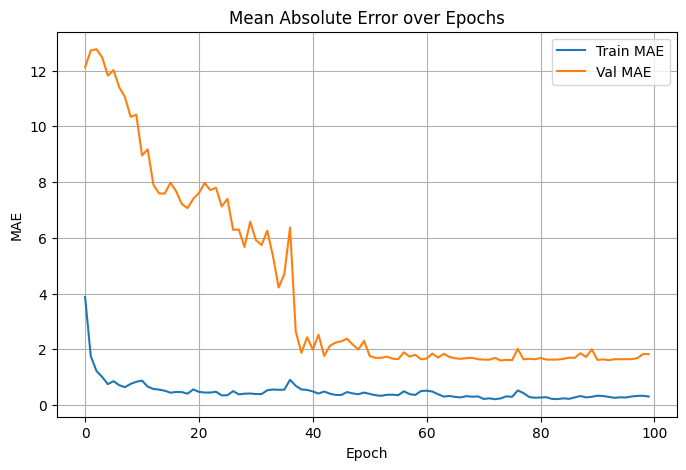

In [10]:
import matplotlib.pyplot as plt

# 1. Retrieve MAE values
train_mae = history.history['mean_absolute_error']       # Training MAE per epoch
val_mae   = history.history['val_mean_absolute_error']   # Validation MAE per epoch

# 2. Plot
plt.figure(figsize=(8, 5))
plt.plot(train_mae, label='Train MAE')
plt.plot(val_mae, label='Val MAE')
plt.title('Mean Absolute Error over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
test_loss, test_mae = model.evaluate(test_ds)
print("Test MAE:", test_mae)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 4.9575 - mean_absolute_error: 1.8323
Test MAE: 1.881320595741272


In [12]:
# Save your model in HDF5 format
model.save("resnet-50-trainable-true-Tongue.h5")

In [13]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout

def build_model(input_shape=(224, 224, 3)):
    # Load ResNet50 without the top classification layers
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)


    for layer in base_model.layers:
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # Add your own fully connected layers if desired
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)

    # Final regression output (1 dimension: predicted Hb)
    predictions = Dense(1, activation='linear')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model


In [14]:
model = build_model(input_shape=(224, 224, 3))
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mean_squared_error',  # or 'mae'
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)


In [15]:
epochs = 100
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - loss: 60.5522 - mean_absolute_error: 6.8188 - val_loss: 81.0839 - val_mean_absolute_error: 8.7952
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 7.1339 - mean_absolute_error: 2.1566 - val_loss: 100.6102 - val_mean_absolute_error: 9.8458
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 5.0349 - mean_absolute_error: 1.7194 - val_loss: 66.0228 - val_mean_absolute_error: 7.8967
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 4.0325 - mean_absolute_error: 1.5616 - val_loss: 55.7493 - val_mean_absolute_error: 7.2175
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 3.3264 - mean_absolute_error: 1.4516 - val_loss: 60.5872 - val_mean_absolute_error: 7.5452
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 3.4008 - mean_absolute_error: 1.5140 - val_loss: 57.2061 - val_mean_absolute_error: 7.3174
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 2.6868 - mean_absolute_error: 1.

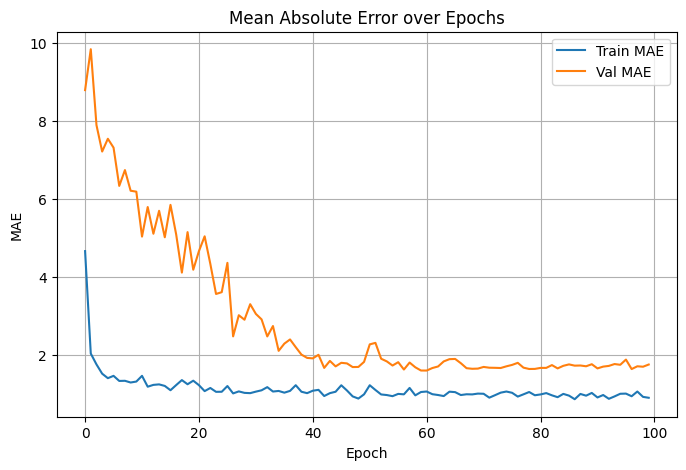

In [16]:
import matplotlib.pyplot as plt

# 1. Retrieve MAE values
train_mae = history.history['mean_absolute_error']       # Training MAE per epoch
val_mae   = history.history['val_mean_absolute_error']   # Validation MAE per epoch

# 2. Plot
plt.figure(figsize=(8, 5))
plt.plot(train_mae, label='Train MAE')
plt.plot(val_mae, label='Val MAE')
plt.title('Mean Absolute Error over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
test_loss, test_mae = model.evaluate(test_ds)
print("Test MAE:", test_mae)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 5.7156 - mean_absolute_error: 1.9546
Test MAE: 1.992264747619629


In [18]:
# Save your model in HDF5 format
model.save("resnet-50-trainable-true_custom-tongue.h5")